# Met Office UKV high-resolution atmosphere model data

:::{eval-rst}
:opticon:`tag`
:badge:`Urban,badge-primary`
:badge:`Sensors,badge-secondary`
:::

## Context
### Purpose
To load, plot, regrid and extract an urban region from the UKV gridded model data using the [Iris package](https://scitools-iris.readthedocs.io/en/stable/).

### Sensor description
Met Office UKV model data is fairly high resolution (approximately 1 km horizontal) and available over the whole of the UK for a variety of atmospheric variables at surface and pressure levels. A selection of variables has been
made openly available as part of the Met Office contribution to the COVID 19 modelling effort. A selection of variables at hourly and daily frequency in NetCDF format can be obtained from [this landing page](https://metdatasa.blob.core.windows.net/covid19-response-non-commercial/README.html). 

This notebook uses a single sample data file for 1.5 m temperature included with the notebook.

### Highlights
* Data for the whole UK is loaded and plotted using Iris
* Data is regridded to a geographic projection 
* A region over London is extracted

### Notebook contributions
#### Authors
Samantha V. Adams, Met Office Informatics Lab, [@svadams](https://github.com/svadams), 03/08/21 (latest version)

#### Reviewers
Alejandro Coca-Castro, The Alan Turing Institute, [@acocac](https://github.com/acocac), 09/08/21 (latest revision)

#### Version
The latest commit of revision is <mark>[74bbb54](https://github.com/acocac/environmental-ai-book/commits/master/book/urban/sensors/urban-sensors-ukv.ipynb)</mark>

### Sensor contributions
#### Dataset originator/creator
Met Office Informatics Lab (creator)
Microsoft (support)
European Regional Development Fund (support)

#### Data Authors:
Met Office

#### Documentation
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "urban-sensors-ukv"
```

:::{note}
Note this data should be used only for non-commercial purposes.
:::

## Install and load libraries

In [1]:
#!conda install -c conda-forge iris

In [2]:
import iris
import iris.analysis
import iris.plot as iplt
from iris.coords import DimCoord
from iris.coord_systems import GeogCS
from iris.cube import Cube

from iris.fileformats.pp import EARTH_RADIUS

import urllib.request

import numpy as np
import matplotlib.pyplot as plt
%matplotlib     inline

## Retrieve and load a sample data file

In [5]:
filepath = 'https://metdatasa.blob.core.windows.net/covid19-response-non-commercial/metoffice_ukv_daily/t1o5m_mean/'
filename = 'ukv_daily_t1o5m_mean_20150801.nc'
urllib.request.urlretrieve(filepath+filename, '../sensors/' + filename)

('../sensors/ukv_daily_t1o5m_mean_20150801.nc',
 <http.client.HTTPMessage at 0x7fc892328ca0>)

In [6]:
air_temp = iris.load_cube('../sensors/' + filename)
air_temp.coord('grid_latitude').guess_bounds()
air_temp.coord('grid_longitude').guess_bounds()

## Visualisation

Here we use the Iris wrapper to matplotlib pyplot to plot the gridded data with added gridlines and coastline.

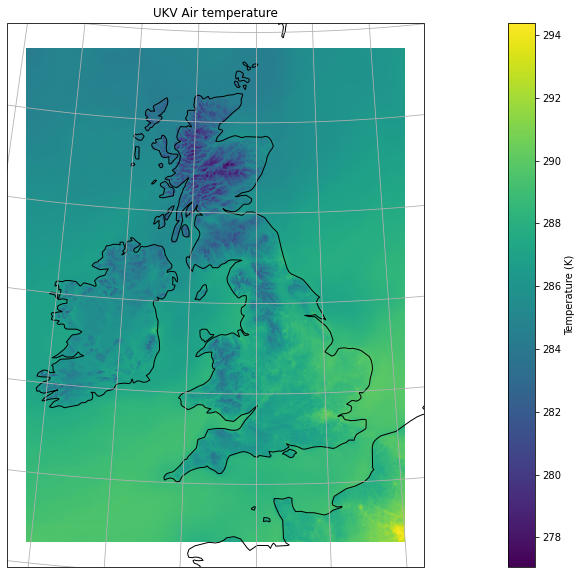

In [15]:
plt.figure(figsize=(30, 10))
iplt.pcolormesh(air_temp)
plt.title("UKV Air temperature", fontsize="xx-large")
cbar = plt.colorbar()
cbar.set_label('Temperature (' + str(air_temp.units) + ')')
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

## Regridding from Azimuthal equal-area projection to geographic

### Create a target cube with a lat-lon coord system for regrid

It is filled with random data so we can plot it to check it looks correct.

In [8]:
latitude = DimCoord(np.linspace(48.5, 59.5, 1222),
                    standard_name='latitude',
                    coord_system = GeogCS(EARTH_RADIUS),
                    units='degrees')
longitude = DimCoord(np.linspace(-10.5, 2.0, 1389),
                     standard_name='longitude',
                    coord_system = GeogCS(EARTH_RADIUS),                     
                     units='degrees')
global_cube = Cube(np.random.uniform(low=0.0, high=1.0, size=(1222, 1389)),
                   dim_coords_and_dims=[(latitude, 0),
                                        (longitude, 1)])

global_cube.coord('latitude').guess_bounds()
global_cube.coord('longitude').guess_bounds()

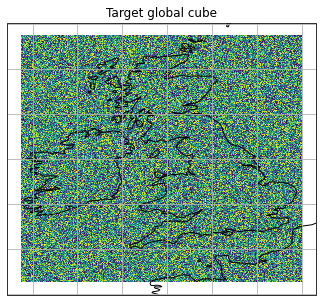

In [9]:
plt.figure(figsize=(30, 10))
iplt.pcolormesh(global_cube)
plt.title("Target global cube", fontsize="xx-large")
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

### Perform the regridding from source data cube to target cube

In [10]:
# Note we need to use extrapolation masking in case regridded source data is actually smaller
# than the target cube extents
global_air_temp = air_temp.regrid(global_cube, iris.analysis.Linear(extrapolation_mode="mask"))

### Plot the regridded data to check it is correct

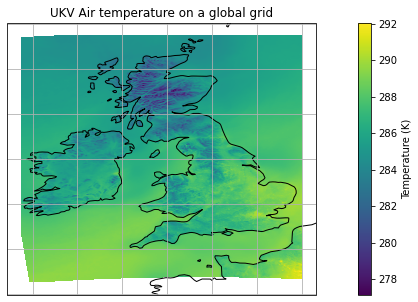

In [11]:
plt.figure(figsize=(30, 10))

iplt.pcolormesh(global_air_temp)
plt.title("UKV Air temperature on a global grid", fontsize="xx-large")
cbar = plt.colorbar()
cbar.set_label('Temperature (' + str(global_air_temp.units) + ')')
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

## Extract the London Region

### Use the Iris Intersection method and supply the region lat-lon bounds

In [12]:
min_lon = -0.52
min_lat = 51.3
max_lon = 0.3
max_lat = 51.7

air_temp_london = global_air_temp.intersection(longitude=(min_lon, max_lon), latitude=(min_lat, max_lat))

### Plot the results

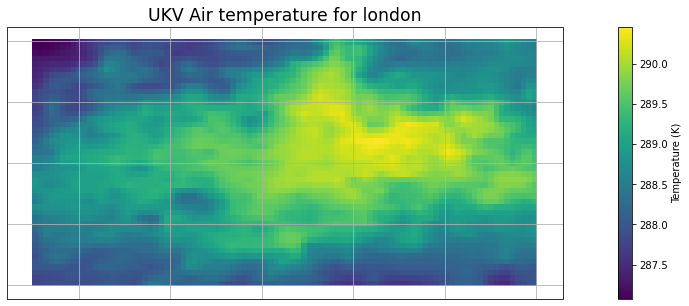

In [21]:
plt.figure(figsize=(20, 5))

iplt.pcolormesh(air_temp_london)
plt.title("UKV Air temperature for london", fontsize="xx-large")
cbar = plt.colorbar()
cbar.set_label('Temperature (' + str(air_temp_london.units) + ')')
ax = plt.gca()
ax.coastlines(resolution="50m")
ax.gridlines()

plt.show()

### Save as a new NetCDF file

In [14]:
iris.save(air_temp_london, '../sensors/ukv_london_sample.nc')

## Summary

This notebook has demonstrated the use of the Iris package to easily load, plot and manipulate gridded environmental NetCDF data.